# Auto Encoder: Pointnet++ (MSG)

In [1]:
# -----------------------
# Imports
# -----------------------
import os
import glob
import random
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
import glob
import random


data_folder = '02_dataset/processed_pc_2048'  # folder containing all 1045 .ply files
all_files = glob.glob(os.path.join(data_folder, '*.npz'))
all_files.sort()

# Keep only first 500
all_files = all_files[:]

# Train/Val split
random.seed(42)
random.shuffle(all_files)

split = int(0.8 * len(all_files))
train_paths = all_files[:split]
val_paths = all_files[split:]


print(f"Total files: {len(all_files)}, Train: {len(train_paths)}, Val: {len(val_paths)}")


Total files: 1045, Train: 836, Val: 209


In [3]:
# -----------------------
# Dataset
# -----------------------
class MaizePointCloudDataset(Dataset):
    def __init__(self, file_paths):
        self.files = file_paths

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        points = data['points']  # [N, 3]
        return torch.from_numpy(points).float()

## Model Architecture

In [4]:
def square_distance(src, dst):
    """
    src: [B, N, 3]
    dst: [B, M, 3]
    return: [B, N, M]
    """
    dist = -2 * torch.matmul(src, dst.transpose(1, 2))
    dist += torch.sum(src ** 2, dim=-1).unsqueeze(-1)
    dist += torch.sum(dst ** 2, dim=-1).unsqueeze(1)
    return dist


**Square_distance**: Pairwise squared Euclidean distance
- **Used for** Finding nearest neighbour, KNN grouping, FPS distance update

In [5]:
def index_points(points, idx):
    """
    points: [B, N, C]
    idx: [B, S] or [B, S, K]
    return: [B, S, C] or [B, S, K, C]
    """
    device = points.device
    B = points.shape[0]

    view_shape = list(idx.shape)
    view_shape.append(points.shape[-1])

    idx = idx.reshape(B, -1)
    batch_indices = torch.arange(B, dtype=torch.long, device=device).view(B, 1)
    batch_indices = batch_indices.repeat(1, idx.shape[1])

    new_points = points[batch_indices, idx, :]
    new_points = new_points.view(*view_shape)

    return new_points


**index_point**: Gather points/feature by index
- **Used for**: FPS centroids, Local neighbour, gather features after kNN 

In [6]:
def farthest_point_sample(xyz, npoint):
    """
    xyz: [B, N, 3]
    return: [B, npoint]
    """
    device = xyz.device
    B, N, _ = xyz.shape

    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device)
    distance = torch.ones(B, N, device=device) * 1e10
    farthest = torch.randint(0, N, (B,), device=device)

    batch_indices = torch.arange(B, device=device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, dim=-1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, dim=-1)[1]

    return centroids


In [7]:
def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    xyz: [B, N, 3]
    new_xyz: [B, S, 3]
    return: [B, S, nsample]
    """
    dist = square_distance(new_xyz, xyz)  # [B, S, N]
    group_idx = dist.argsort(dim=-1)[:, :, :nsample]

    group_dist = torch.gather(dist, 2, group_idx)
    mask = group_dist > radius ** 2

    group_idx[mask] = group_idx[:, :, 0:1].expand_as(group_idx)[mask]
    return group_idx


### Info: 
- npoints : Centroid
- radii : Multiple radius around centroid
- n_samples : points to take inside radius
- in_channel : feature dim from previous layer
- mlp_channel_lsit : MLP per scale
- xyz : [B, N, 3] Input points coordinates
- points : [B, C, N] input point features

In [8]:
class PointNetSetAbstractionMSG(nn.Module):
    def __init__(self, npoint, radii, nsamples, in_channel, mlp_channels_list):
        """
        npoint: number of centroids
        radii: list of radii for MSG
        nsamples: list of nsamples per radius
        in_channel: input feature dimension (0 if only xyz)
        mlp_channels_list: list of MLP configs per scale
        """
        super().__init__()
        assert len(radii) == len(nsamples) == len(mlp_channels_list)

        self.npoint = npoint
        self.radii = radii
        self.nsamples = nsamples

        self.mlp_convs = nn.ModuleList()

        for scale in range(len(radii)):
            layers = []
            last_channel = in_channel + 3  # xyz always appended

            for out_channel in mlp_channels_list[scale]:
                layers.append(nn.Conv2d(last_channel, out_channel, 1, bias=False))
                layers.append(nn.BatchNorm2d(out_channel))
                layers.append(nn.ReLU(inplace=True))
                last_channel = out_channel

            self.mlp_convs.append(nn.Sequential(*layers))

    def forward(self, xyz, points):
        """
        xyz: [B, N, 3]
        points: [B, C, N] or None
        """
        B, N, _ = xyz.shape
        S = self.npoint

        # -------- FPS --------
        if S is not None and S < N:
            fps_idx = farthest_point_sample(xyz, S)
            new_xyz = index_points(xyz, fps_idx)
        else:
            new_xyz = xyz

        new_points_list = []

        # -------- MSG --------
        for i, radius in enumerate(self.radii):
            nsample = self.nsamples[i]

            group_idx = query_ball_point(radius, nsample, xyz, new_xyz)
            grouped_xyz = index_points(xyz, group_idx)
            grouped_xyz = grouped_xyz - new_xyz.unsqueeze(2)

            if points is not None:
                grouped_points = index_points(points.transpose(1, 2), group_idx)
                grouped_points = torch.cat([grouped_xyz, grouped_points], dim=-1)
            else:
                grouped_points = grouped_xyz

            # [B, S, K, C] -> [B, C, S, K]
            grouped_points = grouped_points.permute(0, 3, 1, 2)

            new_points = self.mlp_convs[i](grouped_points)
            new_points = torch.max(new_points, dim=-1)[0]  # max over K

            new_points_list.append(new_points)

        # Concatenate multi-scale features
        new_points_concat = torch.cat(new_points_list, dim=1)

        return new_xyz, new_points_concat


In [9]:
class PointNetPPEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # -------- SA Layer 1 --------
        # 2048 -> 1024
        self.sa1 = PointNetSetAbstractionMSG(
            npoint=1024,
            radii=[0.1, 0.2],
            nsamples=[16, 32],
            in_channel=0,
            mlp_channels_list=[
                [32, 32, 64],
                [64, 64, 128]
            ]
        )

        # -------- SA Layer 2 --------
        # 1024 -> 256
        self.sa2 = PointNetSetAbstractionMSG(
            npoint=256,
            radii=[0.2, 0.4],
            nsamples=[32, 64],
            in_channel=64 + 128,
            mlp_channels_list=[
                [64, 64, 128],
                [128, 128, 256]
            ]
        )

        # -------- SA Layer 3 --------
        # 256 -> 64
        self.sa3 = PointNetSetAbstractionMSG(
            npoint=64,
            radii=[0.4, 0.8],
            nsamples=[64, 128],
            in_channel=128 + 256,
            mlp_channels_list=[
                [128, 128, 256],
                [256, 256, 512]
            ]
        )

        # -------- Global Feature --------
        self.global_mlp = nn.Sequential(
            nn.Conv1d(256 + 512, 512, 1, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, latent_dim, 1)
        )

    def forward(self, xyz):
        """
        xyz: [B, 2048, 3]
        """
        points = None

        l1_xyz, l1_points = self.sa1(xyz, points)      # [B,1024,3], [B,192,1024]
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)  # [B,256,3], [B,384,256]
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)  # [B,64,3],  [B,768,64]

        x = self.global_mlp(l3_points)                  # [B,latent_dim,64]
        x = torch.max(x, 2, keepdim=False)[0]           # [B,latent_dim]

        return x


In [10]:
class PointNetPPDecoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=2048):
        super().__init__()
        self.num_points = num_points

        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_points * 3)
        )

    def forward(self, latent):
        """
        latent: [B, latent_dim]
        """
        x = self.mlp(latent)              # [B, 2048*3]
        x = x.view(-1, self.num_points, 3)
        return x


In [11]:
class PointNetPPAutoEncoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=2048):
        super().__init__()

        self.encoder = PointNetPPEncoder(latent_dim=latent_dim)
        self.decoder = PointNetPPDecoder(
            latent_dim=latent_dim,
            num_points=num_points
        )

    def forward(self, xyz):
        """
        xyz: [B, 2048, 3]
        """
        latent = self.encoder(xyz)
        recon = self.decoder(latent)
        return recon, latent


## Training Loop

In [12]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime


In [13]:
def chamfer_distance(pc1, pc2):
    """
    pc1: [B, N, 3]
    pc2: [B, M, 3]
    """
    dist = torch.cdist(pc1, pc2)  # [B, N, M]

    min_dist_pc1, _ = torch.min(dist, dim=2)  # [B, N]
    min_dist_pc2, _ = torch.min(dist, dim=1)  # [B, M]

    loss = min_dist_pc1.mean() + min_dist_pc2.mean()
    return loss


In [14]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime

In [ ]:
def train_pointnetpp_ae(
    model,
    train_dataset,
    checkpoint_dir,
    device,
    batch_size=8,
    epochs=200,
    lr=1e-3,
    num_workers=4
):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # -----------------------
    # DataLoader
    # -----------------------
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True
    )

    # -----------------------
    # Move model to device
    # -----------------------
    model = model.to(device)

    # -----------------------
    # Optimizer
    # -----------------------
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # -----------------------
    # Resume from checkpoint (if exists)
    # -----------------------
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_latest.pt")
    start_epoch = 0

    if os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1

        # CRITICAL FIX: move optimizer state to device
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)

    # -----------------------
    # Logging
    # -----------------------
    log_file = os.path.join(checkpoint_dir, "train_log.txt")
    log_f = open(log_file, "a")

    def log(msg):
        print(msg)
        log_f.write(msg + "\n")
        log_f.flush()

    log(f"\n=== Training Started: {datetime.now()} ===")
    log(f"Starting from epoch {start_epoch}")

    # -----------------------
    # Training Loop
    # -----------------------
    for epoch in range(start_epoch, epochs):
        model.train()
        epoch_loss = 0.0

        for batch_idx, points in enumerate(train_loader):
            points = points.to(device)  # [B, N, 3]

            optimizer.zero_grad()

            recon, latent = model(points)
            loss = chamfer_distance(recon, points)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        log(f"Epoch [{epoch+1}/{epochs}] | Chamfer Loss: {epoch_loss:.6f}")

        # -----------------------
        # Save checkpoint (every 10 epochs)
        # -----------------------
        if (epoch + 1) % 10 == 0:
            ckpt = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(ckpt, checkpoint_path)
            log(f"✔ Checkpoint saved at epoch {epoch+1}")

        # -----------------------
        # Save snapshot (every 50 epochs)
        # -----------------------
        if (epoch + 1) % 50 == 0:
            snapshot_path = os.path.join(
                checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt"
            )
            torch.save(ckpt, snapshot_path)
            log(f"Snapshot saved: {snapshot_path}")

    # -----------------------
    # Save final model
    # -----------------------
    final_model_path = os.path.join(checkpoint_dir, "pointnetpp_ae_final.pt")
    torch.save(model.state_dict(), final_model_path)

    log(f"✔ Training complete. Final model saved to: {final_model_path}")
    log(f"=== Training Ended: {datetime.now()} ===\n")

    log_f.close()


In [ ]:
from glob import glob

DATA_DIR = "02_dataset/processed_pc_2048"
CHECKPOINT_DIR = "checkpoints/checkpoint_pointnet2"

files = sorted(glob(os.path.join(DATA_DIR, "*.npz")))
train_dataset = MaizePointCloudDataset(files)

model = PointNetPPAutoEncoder(
    latent_dim=128,
    num_points=2048
)

train_pointnetpp_ae(
    model=model,
    train_dataset=train_dataset,
    checkpoint_dir=CHECKPOINT_DIR,
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=8,
    epochs=10000,
    lr=5e-4
)


🔁 Resuming from checkpoint: checkpoints/checkpoint_pointnet2/checkpoint_latest.pt

=== Training Started: 2025-12-18 07:24:09.760673 ===
Starting from epoch 1530


Epoch [1531/10000] | Chamfer Loss: 0.034242
Epoch [1532/10000] | Chamfer Loss: 0.034175
Epoch [1533/10000] | Chamfer Loss: 0.034192
Epoch [1534/10000] | Chamfer Loss: 0.034186
Epoch [1535/10000] | Chamfer Loss: 0.034361
Epoch [1536/10000] | Chamfer Loss: 0.034208
Epoch [1537/10000] | Chamfer Loss: 0.033994
Epoch [1538/10000] | Chamfer Loss: 0.034002
Epoch [1539/10000] | Chamfer Loss: 0.034333
Epoch [1540/10000] | Chamfer Loss: 0.034301
✔ Checkpoint saved at epoch 1540
Epoch [1541/10000] | Chamfer Loss: 0.034110
Epoch [1542/10000] | Chamfer Loss: 0.034327
Epoch [1543/10000] | Chamfer Loss: 0.034350
Epoch [1544/10000] | Chamfer Loss: 0.034108
Epoch [1545/10000] | Chamfer Loss: 0.034056
Epoch [1546/10000] | Chamfer Loss: 0.034133
Epoch [1547/10000] | Chamfer Loss: 0.034191
Epoch [1548/10000] | Chamfer Loss: 0.034098
Epoch [1549/10000] | Chamfer Loss: 0.034175
Epoch [1550/10000] | Chamfer Loss: 0.034198
✔ Checkpoint saved at epoch 1550
📦 Snapshot saved: checkpoints/checkpoint_pointnet2/che

In [18]:
import torch
import os

# Path to save the model
CHECKPOINT_DIR = "checkpoints/checkpoint_pointnet2"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
current_model_path = os.path.join(CHECKPOINT_DIR, "pointnetpp_ae_current.pt")

# Assuming 'model' is your trained model object
torch.save(model.state_dict(), current_model_path)
print(f"✔ Current model saved to: {current_model_path}")


✔ Current model saved to: checkpoints/checkpoint_pointnet2/pointnetpp_ae_current.pt


✔ Model loaded from checkpoints/checkpoint_pointnet2/pointnetpp_ae_current.pt


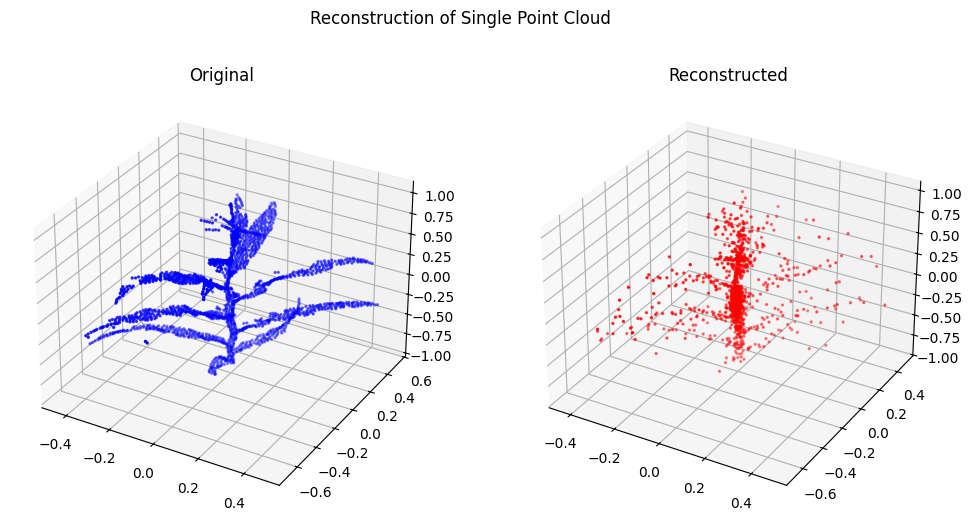

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# from your_dataset_file import MaizePointCloudDataset  # replace with your dataset class
# from your_model_file import PointNetPPAutoEncoder      # replace with your model class

# -------------------------------
# Paths
# -------------------------------
MODEL_PATH = "checkpoints/checkpoint_pointnet2/pointnetpp_ae_current.pt"
POINT_CLOUD_FILE = "02_dataset/processed_pc_2048/0004.npz"  # <-- replace with your file

# -------------------------------
# Device
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# Load model
# -------------------------------
model = PointNetPPAutoEncoder(latent_dim=128, num_points=2048).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print(f"✔ Model loaded from {MODEL_PATH}")

# -------------------------------
# Load point cloud file
# -------------------------------
data = np.load(POINT_CLOUD_FILE)
# Assuming your npz has points stored as 'points'
points = data['points']   # shape: [N, 3]
if points.shape[0] > 2048:
    points = points[:2048]  # take first 2048 points
elif points.shape[0] < 2048:
    # optionally, you can pad points
    pad = 2048 - points.shape[0]
    points = np.vstack([points, points[:pad]])

points_tensor = torch.tensor(points, dtype=torch.float32).unsqueeze(0).to(device)  # [1, N, 3]

# -------------------------------
# Inference
# -------------------------------
with torch.no_grad():
    recon, latent = model(points_tensor)

recon_np = recon.squeeze(0).cpu().numpy()

# -------------------------------
# Plot function
# -------------------------------
def plot_point_clouds(original, reconstructed, title="Point Cloud Reconstruction"):
    fig = plt.figure(figsize=(12, 6))
    
    # Original
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:,0], original[:,1], original[:,2], c='b', s=2)
    ax1.set_title("Original")
    
    # Reconstructed
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reconstructed[:,0], reconstructed[:,1], reconstructed[:,2], c='r', s=2)
    ax2.set_title("Reconstructed")
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Plot
# -------------------------------
plot_point_clouds(points, recon_np, title="Reconstruction of Single Point Cloud")


In [25]:
! pip install pyntcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 KB 9.5 MB/s eta 0:00:0000:01


✔ Model loaded from checkpoints/checkpoint_pointnet2/pointnetpp_ae_current.pt


/home/exouser/01_project/01_AE_triangular_mesh/mesh_env/lib/python3.10/site-packages/pyntcloud/io/ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = property_formats[str(df.dtypes[i])[0]]
/home/exouser/01_project/01_AE_triangular_mesh/mesh_env/lib/python3.10/site-packages/pyntcloud/io/ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = property_formats[str(df.dtypes[i])[0]]
/home/exouser/01_project/01_AE_triangular_mesh/mesh_env/lib/python3.10/site-packages/pyntcloud/io/ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

✔ Reconstructed point cloud saved to reconstructed_ply_1500/recon_0004.ply


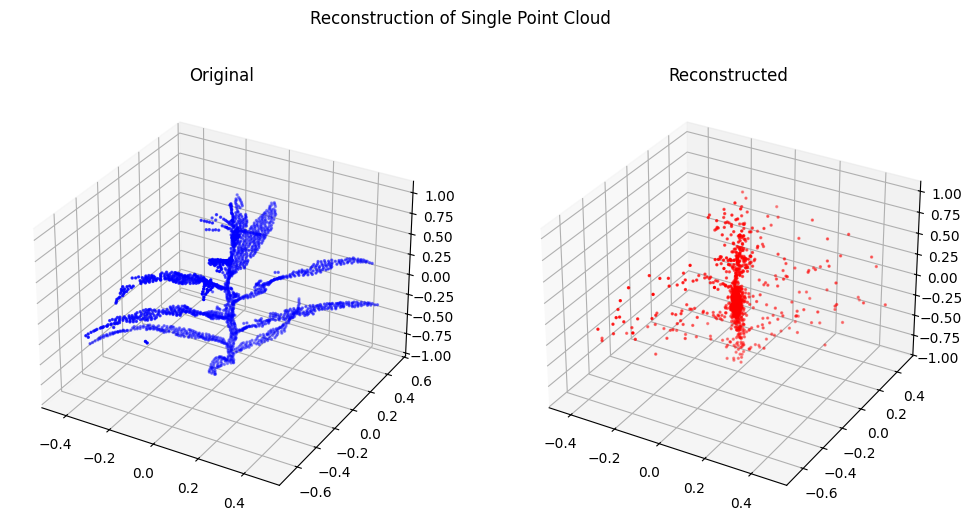

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud  # pip install pyntcloud
import pandas as pd

# -------------------------------
# Paths
# -------------------------------
MODEL_PATH = "checkpoints/checkpoint_pointnet2/pointnetpp_ae_current.pt"
POINT_CLOUD_FILE = "02_dataset/processed_pc_2048/0004.npz"
OUTPUT_PLY = "reconstructed_ply_1500/recon_0004.ply"

# -------------------------------
# Device
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# Load model
# -------------------------------
model = PointNetPPAutoEncoder(latent_dim=128, num_points=2048).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print(f"✔ Model loaded from {MODEL_PATH}")

# -------------------------------
# Load point cloud file
# -------------------------------
data = np.load(POINT_CLOUD_FILE)
points = data['points']  # shape: [N, 3]

# Ensure 2048 points
if points.shape[0] > 2048:
    points = points[:2048]
elif points.shape[0] < 2048:
    pad = 2048 - points.shape[0]
    points = np.vstack([points, points[:pad]])

points_tensor = torch.tensor(points, dtype=torch.float32).unsqueeze(0).to(device)  # [1, N, 3]

# -------------------------------
# Inference
# -------------------------------
with torch.no_grad():
    recon, latent = model(points_tensor)

recon_np = recon.squeeze(0).cpu().numpy()

# -------------------------------
# Optional: downsample to 1500 points
# -------------------------------
if recon_np.shape[0] > 1500:
    idx = np.random.choice(recon_np.shape[0], 1500, replace=False)
    recon_np = recon_np[idx]

# -------------------------------
# Save reconstructed point cloud as .ply
# -------------------------------
import os
os.makedirs(os.path.dirname(OUTPUT_PLY), exist_ok=True)

df = pd.DataFrame(recon_np, columns=['x','y','z'])
cloud = PyntCloud(df)
cloud.to_file(OUTPUT_PLY)
print(f"✔ Reconstructed point cloud saved to {OUTPUT_PLY}")

# -------------------------------
# Plot function
# -------------------------------
def plot_point_clouds(original, reconstructed, title="Point Cloud Reconstruction"):
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:,0], original[:,1], original[:,2], c='b', s=2)
    ax1.set_title("Original")
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reconstructed[:,0], reconstructed[:,1], reconstructed[:,2], c='r', s=2)
    ax2.set_title("Reconstructed")
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Plot
# -------------------------------
plot_point_clouds(points, recon_np, title="Reconstruction of Single Point Cloud")
